### Project 1

#### Part A

Jerônimo de Abreu Afrange

- Select 30 stocks in the S&P 500 universe
- Collect daily returns for the past 10 years (2014-2023)
- Create both value-weighted and equally weighted portfolio
- Rebalance these portfolios in the first day of the month based on the information on the last day (1-day lag)
- Which portfolio has the highest turnover?
- Compute daily returns for both portfolios
- Compute the following statistics for these portfolios:
    - Annualized average return
    - Annualized standar deviation
    - Sharpe ratio
    - Information ratio (vs S&P500)
- Plot cumulative returns for both portfolios, S&P500 and risk-free




In [20]:
import pandas as pd
import dateutil.relativedelta

from matplotlib import pyplot as plt

In [ ]:
# AUXILIARY FUNCTIONS

# calculates the month number
def month_number(date, start_date):
    delta = dateutil.relativedelta.relativedelta(date, start_date)
    return delta.years * 12 + delta.months

In [ ]:
# DATA LOADING AND INITIAL MANIPULATION

# creates the DataFrames for de S&P500 index and de stock prices
stocks_data = pd.read_csv("../data/stock_prices.csv")
index_data = pd.read_csv("../data/sp500_index.csv")

# removes the stocks of which we don't have data from 2014 to the current day
incomplete_stocks = stocks_data["Ticker"].value_counts()
incomplete_stocks = incomplete_stocks[incomplete_stocks < incomplete_stocks.max()]
stocks_data = stocks_data[~stocks_data["Ticker"].isin(incomplete_stocks.index)]

In [ ]:
# CALCULATION OF THE DAILY RETURNS AND CREATION OF THE MONTH NUMBER COLUMN

# creation of the daily return column
stocks_data["RETURN"] = stocks_data["PX_LAST"] / stocks_data["PX_OPEN"] - 1

# creation of the month number column
stocks_data["Date"] = pd.to_datetime(stocks_data["Date"])
stocks_data["MONTH_NUMBER"] = stocks_data["Date"].apply(lambda x: month_number(x, stocks_data["Date"].min()))

# defines a few constants
INITIAL_DATE = stocks_data["Date"].min()
INITIAL_PORT_VALUE = 1e6

In [78]:
# CREATION OF THE VALUE WEIGHTED PORTFOLIO

# creates the porfolio DataFrame, which is a copy of the current stocks_data DataFrame
portfolio_vw = stocks_data.copy()

# convenience variables
initial_date_filter = portfolio_vw["Date"] == INITIAL_DATE

# creation of the column for the total market cap of the stocks and column of the share of the total
portfolio_vw["TOTAL_MKT_CAP"] = portfolio_vw.groupby("Date")["CUR_MKT_CAP"].transform("sum")
portfolio_vw["MKT_CAP_SHARE"] = portfolio_vw["CUR_MKT_CAP"] / portfolio_vw["TOTAL_MKT_CAP"]

# creation of the initial porfolio stock ammount for each stock and propagation to the entire DataFrame
portfolio_vw.loc[initial_date_filter, "PORT_STOCK_AMT"] = INITIAL_PORT_VALUE * portfolio_vw["MKT_CAP_SHARE"] / portfolio_vw["PX_OPEN"]
stock_amounts = portfolio_vw.loc[initial_date_filter, ["Ticker", "PORT_STOCK_AMT"]]
portfolio_vw = portfolio_vw.drop(columns="PORT_STOCK_AMT")
portfolio_vw = portfolio_vw.merge(stock_amounts, on="Ticker")

# calculation of the values of the individual positions as well as the total portfolio value
portfolio_vw["PORT_STOCK_VAL_LAST"] = portfolio_vw["PX_LAST"] * portfolio_vw["PORT_STOCK_AMT"]
portfolio_vw["PORT_TOTAL_VAL_LAST"] = portfolio_vw.groupby("Date")["PORT_STOCK_VAL_LAST"].transform("sum")

# creates a copy of the current portfolio for future comparison
portfolio_vw_unbalanced = portfolio_vw.copy()

# rebalancing loop
for i in range(1, portfolio_vw["MONTH_NUMBER"].max() + 1):

    # convenience filters
    ending_date_filter = portfolio_vw["Date"] == portfolio_vw[portfolio_vw["MONTH_NUMBER"] == i - 1]["Date"].max()
    initial_date_filter = portfolio_vw["Date"] == portfolio_vw[portfolio_vw["MONTH_NUMBER"] == i]["Date"].min()
    current_month_filter = portfolio_vw["MONTH_NUMBER"] >= i
    
    # rebalancing of the number of shares and propagation to the rest of the DataFrame
    current_portfolio_value = portfolio_vw[ending_date_filter]["PORT_TOTAL_VAL_LAST"].iloc[0]
    portfolio_vw.loc[initial_date_filter, "PORT_STOCK_AMT"] = INITIAL_PORT_VALUE * portfolio_vw["MKT_CAP_SHARE"] / portfolio_vw["PX_OPEN"]
    stock_amounts = portfolio_vw.loc[initial_date_filter, ["Ticker", "PORT_STOCK_AMT"]]
    stock_amounts["MONTH_NUMBER"] = i
    portfolio_vw = pd.merge(portfolio_vw, stock_amounts, on=["Ticker", "MONTH_NUMBER"], how="left", suffixes=("", "_new"))
    portfolio_vw["PORT_STOCK_AMT"] = portfolio_vw["PORT_STOCK_AMT_new"].combine_first(portfolio_vw["PORT_STOCK_AMT"])
    portfolio_vw.drop(columns=["PORT_STOCK_AMT_new"], inplace=True)

    # calculating the new portfolio values
    portfolio_vw.loc[current_month_filter, "PORT_STOCK_VAL_LAST"] = portfolio_vw["PX_LAST"] * portfolio_vw["PORT_STOCK_AMT"]
    portfolio_vw.loc[current_month_filter, "PORT_TOTAL_VAL_LAST"] = portfolio_vw.groupby("Date")["PORT_STOCK_VAL_LAST"].transform("sum")

In [79]:
portfolio_vw[portfolio_vw["Ticker"] == "DIS"]

,Date,PX_LAST,PX_OPEN,PX_HIGH,PX_LOW,PX_VOLUME,CUR_MKT_CAP,Ticker,RETURN,MONTH_NUMBER,TOTAL_MKT_CAP,MKT_CAP_SHARE,PORT_STOCK_AMT,PORT_STOCK_VAL_LAST,PORT_TOTAL_VAL_LAST
0,2014-01-02,76.27,76.04,76.5000,75.90,5212460.0,134027.7199,DIS,0.003025,0,1.005353e+06,0.133314,1753.209324,133717.275159,9.968894e+05
1,2014-01-03,76.11,76.30,76.6970,76.01,4061042.0,133746.5552,DIS,-0.002490,0,1.002988e+06,0.133348,1753.209324,133436.761667,9.945225e+05
2,2014-01-06,75.82,76.53,76.8400,75.49,6816693.0,133236.9441,DIS,-0.009277,0,1.006224e+06,0.132413,1753.209324,132928.330963,9.977213e+05
3,2014-01-07,76.34,76.12,76.7000,75.90,4511157.0,134150.7295,DIS,0.002890,0,1.018683e+06,0.131690,1753.209324,133839.999811,1.010070e+06
4,2014-01-08,75.22,76.13,76.2800,74.81,10914858.0,132182.5763,DIS,-0.011953,0,1.018454e+06,0.129787,1753.209324,131876.405368,1.009840e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2665,2024-08-06,89.97,88.23,91.9100,87.96,21717509.0,164019.1810,DIS,0.019721,127,3.359677e+06,0.048820,509.574496,45846.417388,9.623469e+05
2666,2024-08-07,85.96,88.00,89.2447,85.75,30581926.0,155895.9712,DIS,-0.023182,127,3.338005e+06,0.046703,509.574496,43803.023660,9.571886e+05
2667,2024-08-08,85.96,85.15,86.3300,83.91,21890474.0,155895.9712,DIS,0.009513,127,3.407948e+06,0.045745,509.574496,43803.023660,9.772902e+05
2668,2024-08-09,86.21,86.13,86.2500,84.71,16008396.0,156349.3680,DIS,0.000929,127,3.427590e+06,0.045615,509.574496,43930.417284,9.832184e+05


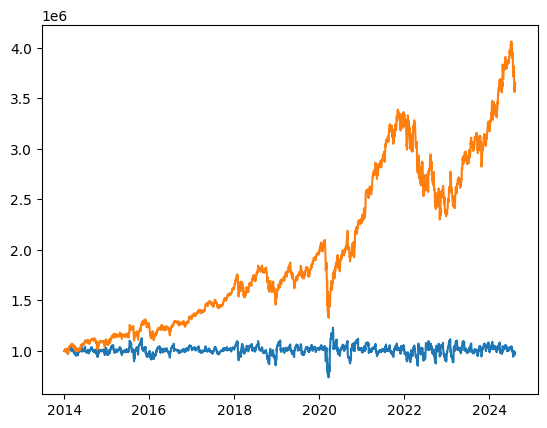

In [81]:
plt.plot(portfolio_vw.loc[portfolio_vw["Ticker"] == "DIS", "Date"], portfolio_vw.loc[portfolio_vw["Ticker"] == "DIS", "PORT_TOTAL_VAL_LAST"])
plt.plot(portfolio_vw_unbalanced.loc[portfolio_vw_unbalanced["Ticker"] == "DIS", "Date"], portfolio_vw_unbalanced.loc[portfolio_vw_unbalanced["Ticker"] == "DIS", "PORT_TOTAL_VAL_LAST"])
plt.show()